In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

In [4]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])

print (str(Y_hat - Y))

# 残差平方和
SE = (Y_hat - Y) ** 2
print(str(SE))

print(str(np.sum(SE)))

[ 0.  -0.5  1.  -1.  -3. ]
[ 0.    0.25  1.    1.    9.  ]
11.25


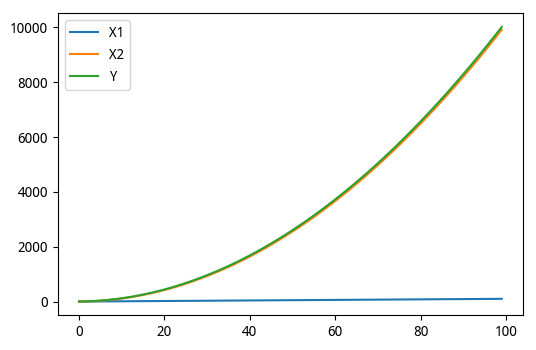

In [6]:
X1 = np.arange(100)

X2 = np.array([i ** 2 for i in range(100)]) + X1

Y = X1 + X2

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(Y, label='Y')
plt.legend();

In [11]:
X = sm.add_constant( np.column_stack((X1, X2)))

results = regression.linear_model.OLS(Y, X).fit()

print('Beta_0:', results.params[0])
print('Beta_1:', results.params[1])
print('Beta_2:', results.params[2])

Beta_0: 2.55795384874e-13
Beta_1: 1.0
Beta_2: 1.0


In [24]:
start_date = '2014-01-01'
end_date = '2015-01-01'

szzs = get_price("000001.XSHG",start_date=start_date,end_date=end_date,fields = 'ClosingPx')
hs300 = get_price("000300.XSHG",start_date=start_date,end_date=end_date,fields = 'ClosingPx')
cybz = get_price("399006.XSHE",start_date=start_date,end_date=end_date,fields = 'ClosingPx')

slr = regression.linear_model.OLS(szzs, sm.add_constant(cybz)).fit()

print(slr.params[1])

2.07699253299


In [25]:
mlr = regression.linear_model.OLS(szzs, sm.add_constant(np.column_stack((cybz, hs300)))).fit()

prediction = mlr.params[0] + mlr.params[1]*cybz + mlr.params[2]*hs300
prediction.name = 'Prediction'

print('MLR beta of cybz:', mlr.params[1], '\nMLR beta of 000300:', mlr.params[2])

MLR beta of cybz: 0.149306602242 
MLR beta of 000300: 0.868609350721


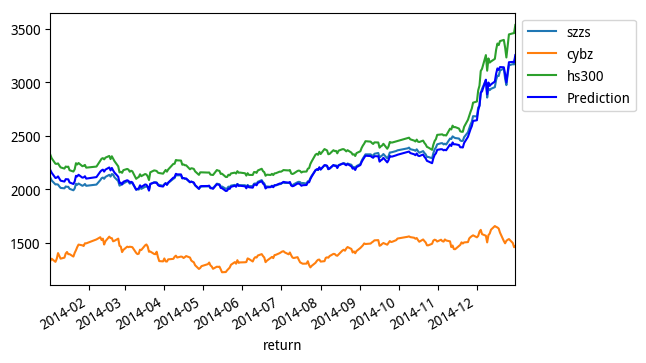

In [27]:
szzs.name = 'szzs'
cybz.name = 'cybz'
hs300.name = 'hs300'

szzs.plot()
cybz.plot()
hs300.plot()
prediction.plot(color='b')
plt.xlabel('return')
plt.legend(bbox_to_anchor=(1,1), loc=2);

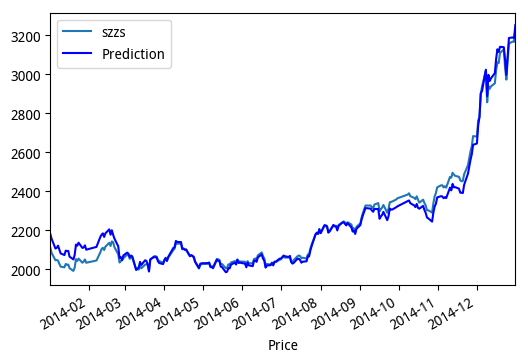

In [29]:
szzs.plot()
prediction.plot(color='b')
plt.xlabel('Price')
plt.legend();

In [30]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   szzs   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     8021.
Date:                Thu, 07 Sep 2017   Prob (F-statistic):          6.57e-222
Time:                        17:25:44   Log-Likelihood:                -1219.6
No. Observations:                 245   AIC:                             2445.
Df Residuals:                     242   BIC:                             2456.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -36.2917     35.164     -1.032      0.303      -105.559    32.975
x1             0.1493      0.032      4.697      0.000         0.087     0.212
x2             0.8686      0.009     92.454      0.000         0.850     0.887
==============================================================================
Omnibus:                       12.624   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.679
Skew:                          -0.577   Prob(JB):                      0.00107
Kurtosis:                       2.918   Cond. No.                     4.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

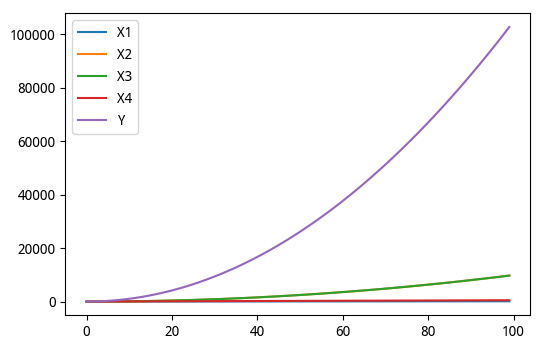

In [31]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend();

In [33]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print("Beta_0: ", results.params[0])
print("Beta_1: ", results.params[1])
print("Beta_2: ", results.params[2])
print("Beta_3: ", results.params[3])
print("Beta_4: ", results.params[4])

Beta_0:  -2.56932253251e-11
Beta_1:  0.269230769231
Beta_2:  0.499999999991
Beta_3:  10.0
Beta_4:  1.34615384615


In [35]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')

In [36]:
# 逐步回归
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    
    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(Y, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(Y, selected).fit()
    return model

In [37]:
result = forward_aic(Y, data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.784e+26
Date:                Thu, 07 Sep 2017   Prob (F-statistic):               0.00
Time:                        17:32:25   Log-Likelihood:                 1752.9
No. Observations:                 100   AIC:                            -3498.
Df Residuals:                      96   BIC:                            -3487.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.684e-11   4.16e-09      0.011      0.991     -8.21e-09   8.3e-09
X3            10.0000   2.52e-09   3.97e+09      0.000        10.000    10.000
X1             0.2692   7.69e-12    3.5e+10      0.000         0.269     0.269
X2             0.5000   2.52e-09   1.99e+08      0.000         0.500     0.500
X4             1.3462   3.85e-11    3.5e+10      0.000         1.346     1.346
==============================================================================
Omnibus:                       14.003   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.024
Skew:                           0.651   Prob(JB):                      0.00666
Kurtosis:                       2.156   Cond. No.                     5.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.52e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""